<a href="https://colab.research.google.com/github/prakash-bisht/GAI-LLM/blob/main/Semantic_Chunking_Advanced_Chunking_Strategy_Lanchain_Groq_RAGAS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install -qU langchain_experimental langchain_openai langchain_community langchain ragas chromadb langchain-groq fastembed
! pip install pypdf openai
! wget "https://arxiv.org/pdf/1810.04805.pdf"

In [13]:
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter

loader = PyPDFLoader("1810.04805.pdf")
documents = loader.load()

print(len(documents))

16


## RecursiveCharacterTextSplitter AKA "Naive Chunking"

In [14]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=0,
    length_function=len,
    is_separator_regex=False
)

In [15]:
naive_chunks = text_splitter.split_documents(documents)
for chunk in naive_chunks[10:15]:
  print(chunk.page_content+ "\n")

BERT BERT
E[CLS] E1  E[SEP]... EN E1’ ... EM’
C
 T1
 T[SEP]...
 TN
 T1’ ...
 TM’
[CLS] Tok 1  [SEP]... Tok N Tok 1 ... TokM
Question Paragraph
Start/End Span
BERT
E[CLS] E1  E[SEP]... EN E1’ ... EM’
C
 T1
 T[SEP]...
 TN
 T1’ ...
 TM’
[CLS] Tok 1  [SEP]... Tok N Tok 1 ... TokM
Masked Sentence A Masked Sentence B
Pre-training Fine-Tuning
NSP Mask LM Mask LM
Unlabeled Sentence A and B Pair 
SQuAD
Question Answer Pair
NERMNLI
Figure 1: Overall pre-training and ﬁne-tuning procedures for BERT. Apart from output layers, the same architec-
tures are used in both pre-training and ﬁne-tuning. The same pre-trained model parameters are used to initialize
models for different down-stream tasks. During ﬁne-tuning, all parameters are ﬁne-tuned. [CLS] is a special
symbol added in front of every input example, and [SEP] is a special separator token (e.g. separating ques-
tions/answers).
ing and auto-encoder objectives have been used
for pre-training such models (Howard and Ruder,

2018; Radford et al.,

## Instantiate Embeding Model

In [16]:
from langchain_community.embeddings.fastembed import FastEmbedEmbeddings
embed_model = FastEmbedEmbeddings(model_name="BAAI/bge-base-en-v1.5")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

## Semantic Chunking
Now let's implement the `SemanticChunker`!

We're going to be using the `percentile` threshold as an example today - but there's three different strategies you could use (descriptions provided by the [LangChain docs](https://python.langchain.com/docs/modules/data_connection/document_transformers/semantic-chunker) on Semantic Chunking):

- `percentile` (default) - In this method, all differences between sentences are calculated, and then any difference greater than the X percentile is split.

- `standard_deviation` - In this method, any difference greater than X standard deviations is split.

- `interquartile` - In this method, the interquartile distance is used to split chunks.

The basic idea is as follows:

1. Split our document into sentences (based on `.`, `?`, and `!`)
2. Index each sentence based on position
3. Add a `buffer_size` (`int`) of sentences on either side of our selected sentence
4. Calculate distances between groups of sentences
5. Merge groups based on similarity based on the above thresholds

> NOTE: This method is currently experimental and is not in a stable final form - expect updates and improvements in the coming months



In [17]:
from langchain_experimental.text_splitter import SemanticChunker
from langchain_openai.embeddings import OpenAIEmbeddings

semantic_chunker = SemanticChunker(embed_model, breakpoint_threshold_type="percentile")

#### Create semantic chunk from the documents

In [18]:
semantic_chunks = semantic_chunker.create_documents([d.page_content for d in documents])

In [19]:
for semantic_chunk in semantic_chunks:
  if "Effect of Pre-training Tasks" in semantic_chunk.page_content:
    print(semantic_chunk.page_content)
    print(len(semantic_chunk.page_content))

Dev Set
Tasks MNLI-m QNLI MRPC SST-2 SQuAD
(Acc) (Acc) (Acc) (Acc) (F1)
BERTBASE 84.4 88.4 86.7 92.7 88.5
No NSP 83.9 84.9 86.5 92.6 87.9
LTR & No NSP 82.1 84.3 77.5 92.1 77.8
+ BiLSTM 82.1 84.1 75.7 91.6 84.9
Table 5: Ablation over the pre-training tasks using the
BERTBASE architecture. “No NSP” is trained without
the next sentence prediction task. “LTR & No NSP” is
trained as a left-to-right LM without the next sentence
prediction, like OpenAI GPT. “+ BiLSTM” adds a ran-
domly initialized BiLSTM on top of the “LTR + No
NSP” model during ﬁne-tuning. ablation studies can be found in Appendix C. 5.1 Effect of Pre-training Tasks
We demonstrate the importance of the deep bidi-
rectionality of BERT by evaluating two pre-
training objectives using exactly the same pre-
training data, ﬁne-tuning scheme, and hyperpa-
rameters as BERTBASE :
No NSP : A bidirectional model which is trained
using the “masked LM” (MLM) but without the
“next sentence prediction” (NSP) task. LTR & No NSP: A left-con

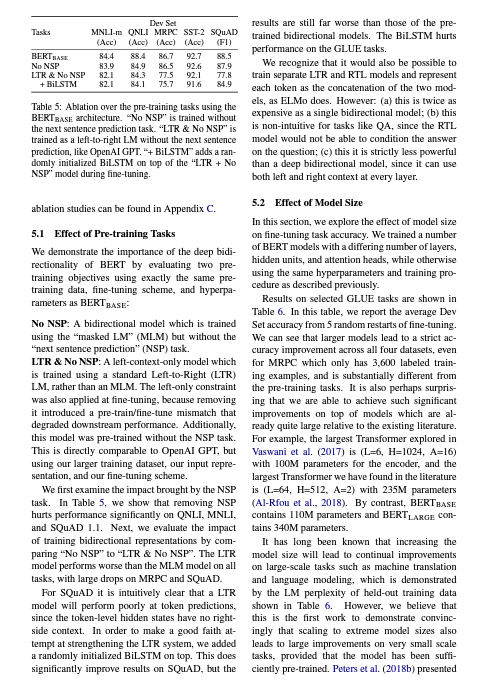

In [20]:
print(len(semantic_chunks))

56


## Instantiate LLM

In [22]:
from google.colab import userdata
from groq import Groq
from langchain_groq import ChatGroq
#
groq_api_key = ""
#

## Instantiate the Vectorstore

In [23]:
from langchain_community.vectorstores import Chroma
semantic_chunk_vectorstore = Chroma.from_documents(semantic_chunks, embedding=embed_model)

We will "limit" our semantic retriever to k = 1 to demonstrate the power of the semantic chunking strategy while maintaining similar token counts between the semantic and naive retrieved context.

## Retrieval

In [24]:
semantic_chunk_retriever = semantic_chunk_vectorstore.as_retriever(search_kwargs={"k" : 1})


In [25]:
semantic_chunk_retriever.invoke("Describe the Feature-based Approach with BERT?")

[Document(metadata={}, page_content='The right part of the paper represents the\nDev set results. For the feature-based approach,\nwe concatenate the last 4 layers of BERT as the\nfeatures, which was shown to be the best approach\nin Section 5.3. From the table it can be seen that ﬁne-tuning is\nsurprisingly robust to different masking strategies. However, as expected, using only the MASK strat-\negy was problematic when applying the feature-\nbased approach to NER. Interestingly, using only\nthe R ND strategy performs much worse than our\nstrategy as well.')]

## Augmentation

In [26]:
from langchain_core.prompts import ChatPromptTemplate

rag_template = """\
Use the following context to answer the user's query. If you cannot answer, please respond with 'I don't know'.

User's Query:
{question}

Context:
{context}
"""

rag_prompt = ChatPromptTemplate.from_template(rag_template)

## Generation

In [31]:
chat_model = ChatGroq(temperature=0,
                      model_name="llama-3.1-8b-instant",
                      api_key=groq_api_key,)

## Creating a RAG Pipeline Utilizing Semantic Chunking

In [32]:
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser

semantic_rag_chain = (
    {"context" : semantic_chunk_retriever, "question" : RunnablePassthrough()}
    | rag_prompt
    | chat_model
    | StrOutputParser()
)

## Ask a question

In [33]:
semantic_rag_chain.invoke("Describe the Feature-based Approach with BERT?")

'The Feature-based Approach with BERT involves concatenating the last 4 layers of the BERT model as features. This approach is mentioned in the context as the best approach, as shown in Section 5.3. \n\nIn this approach, the features extracted from the last 4 layers of BERT are used as input for the task at hand, rather than fine-tuning the entire BERT model. This can be useful when the task requires a specific set of features that are not captured by the entire BERT model, or when fine-tuning the entire model is computationally expensive or not feasible.\n\nThe Feature-based Approach with BERT is contrasted with fine-tuning the entire BERT model, which is shown to be surprisingly robust to different masking strategies. However, the Feature-based Approach is problematic when applied to certain tasks, such as Named Entity Recognition (NER), and may not perform as well as other strategies, such as using the R ND strategy.'

## Implement a RAG pipeline using Naive Chunking Startegy

In [34]:
naive_chunk_vectorstore = Chroma.from_documents(naive_chunks, embedding=embed_model)

Notice that we're going to use k = 10 here - this is to "make it a fair comparison" between the two strategies.

In [35]:
naive_chunk_retriever = naive_chunk_vectorstore.as_retriever(search_kwargs={"k" : 5})

In [36]:
naive_rag_chain = (
    {"context" : naive_chunk_retriever, "question" : RunnablePassthrough()}
    | rag_prompt
    | chat_model
    | StrOutputParser()
)

## Ask Question

In [37]:
naive_rag_chain.invoke("Describe the Feature-based Approach with BERT?")

'The Feature-based Approach with BERT involves extracting the activations from one or more layers of the pre-trained BERT model without fine-tuning any parameters. These contextual embeddings are then used as input to a randomly initialized two-layer 768-dimensional BiLSTM before the classification layer.\n\nIn this approach, the top four hidden layers of the pre-trained Transformer are concatenated to form the features, which is shown to be the best approach. The results demonstrate that BERT is effective for both fine-tuning and feature-based approaches, with the feature-based approach being surprisingly robust to different masking strategies.\n\nThe feature-based approach with BERT can be summarized as follows:\n\n1. Extract the activations from one or more layers of the pre-trained BERT model.\n2. Use these contextual embeddings as input to a randomly initialized two-layer 768-dimensional BiLSTM.\n3. Concatenate the token representations from the top four hidden layers of the pre-t

## Ragas Assessment Comparison


In [38]:
synthetic_data_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=0,
    length_function=len,
    is_separator_regex=False
)

In [39]:
synthetic_data_chunks = synthetic_data_splitter.create_documents([d.page_content for d in documents])
print(len(synthetic_data_chunks))

72


## Then we will create:

```
Questions - synthetically generated (gpt-3.5-turbo)
Contexts - created above
Ground Truths - synthetically generated (gpt-4-turbo-preview)
Answers - generated from our Semantic RAG Chain
```

In [40]:
questions = []
ground_truths_semantic = []
contexts = []
answers = []

question_prompt = """\
You are a teacher preparing a test. Please create a question that can be answered by referencing the following context.

Context:
{context}
"""

question_prompt = ChatPromptTemplate.from_template(question_prompt)

ground_truth_prompt = """\
Use the following context and question to answer this question using *only* the provided context.

Question:
{question}

Context:
{context}
"""

ground_truth_prompt = ChatPromptTemplate.from_template(ground_truth_prompt)

question_chain = question_prompt | chat_model | StrOutputParser()
ground_truth_chain = ground_truth_prompt | chat_model | StrOutputParser()

for chunk in synthetic_data_chunks[10:14]:
  questions.append(question_chain.invoke({"context" : chunk.page_content}))
  contexts.append([chunk.page_content])
  ground_truths_semantic.append(ground_truth_chain.invoke({"question" : questions[-1], "context" : contexts[-1]}))
  answers.append(semantic_rag_chain.invoke(questions[-1]))

In [41]:
len(questions), len(answers), len(contexts), len(ground_truths_semantic)

(4, 4, 4, 4)

In [42]:
questions[0]

"Here's a test question based on the provided context:\n\n**Question:** What is the purpose of the special symbol [SEP] in the BERT model?\n\n**A)** It is used to separate input tokens.\n**B)** It is used to separate questions and answers.\n**C)** It is used to separate masked tokens.\n**D)** It is used to separate input examples.\n\n**Correct Answer:** B) It is used to separate questions and answers.\n\nThis question requires the student to understand the context and identify the specific purpose of the [SEP] symbol in the BERT model."

In [43]:
answers[0]

'The purpose of the special symbol [SEP] in the BERT model is to separate questions and answers.'

In [47]:
ground_truths_semantic[0]

'The correct answer is B) It is used to separate questions and answers.\n\nThis is directly stated in the context: "[SEP] is a special separator token (e.g. separating questions/answers)."'

In [44]:
contexts[0]

['BERT BERT\nE[CLS] E1  E[SEP]... EN E1’ ... EM’\nC\n T1\n T[SEP]...\n TN\n T1’ ...\n TM’\n[CLS] Tok 1  [SEP]... Tok N Tok 1 ... TokM\nQuestion Paragraph\nStart/End Span\nBERT\nE[CLS] E1  E[SEP]... EN E1’ ... EM’\nC\n T1\n T[SEP]...\n TN\n T1’ ...\n TM’\n[CLS] Tok 1  [SEP]... Tok N Tok 1 ... TokM\nMasked Sentence A Masked Sentence B\nPre-training Fine-Tuning\nNSP Mask LM Mask LM\nUnlabeled Sentence A and B Pair \nSQuAD\nQuestion Answer Pair\nNERMNLI\nFigure 1: Overall pre-training and ﬁne-tuning procedures for BERT. Apart from output layers, the same architec-\ntures are used in both pre-training and ﬁne-tuning. The same pre-trained model parameters are used to initialize\nmodels for different down-stream tasks. During ﬁne-tuning, all parameters are ﬁne-tuned. [CLS] is a special\nsymbol added in front of every input example, and [SEP] is a special separator token (e.g. separating ques-\ntions/answers).\ning and auto-encoder objectives have been used\nfor pre-training such models (Howar

## Format the content into HuggingFace Dataset Format

In [45]:
from datasets import load_dataset, Dataset

qagc_list = []

for question, answer, context, ground_truth in zip(questions, answers, contexts, ground_truths_semantic):
  qagc_list.append({
      "question" : question,
      "answer" : answer,
      "contexts" : context,
      "ground_truth" : ground_truth
  })

eval_dataset = Dataset.from_list(qagc_list)

In [46]:
eval_dataset

Dataset({
    features: ['question', 'answer', 'contexts', 'ground_truth'],
    num_rows: 4
})

## Implement Ragas metrics and evaluate our created dataset.

In [48]:
from ragas.metrics import (
    answer_relevancy,
    faithfulness,
    context_recall,
    context_precision,
)

/usr/local/lib/python3.12/dist-packages/google/colab/_import_hooks/_hook_injector.py:55: FutureWarning: 

All support for the `google.generativeai` package has ended. It will no longer be receiving 
updates or bug fixes. Please switch to the `google.genai` package as soon as possible.
See README for more details:

https://github.com/google-gemini/deprecated-generative-ai-python/blob/main/README.md

  loader.exec_module(module)
/tmp/ipython-input-2829690427.py:1: DeprecationWarning: Importing answer_relevancy from 'ragas.metrics' is deprecated and will be removed in v1.0. Please use 'ragas.metrics.collections' instead. Example: from ragas.metrics.collections import answer_relevancy
  from ragas.metrics import (
/tmp/ipython-input-2829690427.py:1: DeprecationWarning: Importing faithfulness from 'ragas.metrics' is deprecated and will be removed in v1.0. Please use 'ragas.metrics.collections' instead. Example: from ragas.metrics.collections import faithfulness
  from ragas.metrics import (

In [49]:
from ragas import evaluate

result = evaluate(
    eval_dataset,
    metrics=[
        context_precision,
        faithfulness,
        answer_relevancy,
        context_recall,
    ],
     llm=chat_model,
    embeddings=embed_model,
    raise_exceptions=False
)

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

ERROR:ragas.executor:Exception raised in Job[2]: ValidationError(1 validation error for EmbeddingUsageEvent
model
  Input should be a valid string [type=string_type, input_value=<fastembed.text.text_embe...bject at 0x7e52ed11a8a0>, input_type=TextEmbedding]
    For further information visit https://errors.pydantic.dev/2.12/v/string_type)
ERROR:ragas.executor:Exception raised in Job[10]: ValidationError(1 validation error for EmbeddingUsageEvent
model
  Input should be a valid string [type=string_type, input_value=<fastembed.text.text_embe...bject at 0x7e52ed11a8a0>, input_type=TextEmbedding]
    For further information visit https://errors.pydantic.dev/2.12/v/string_type)
ERROR:ragas.executor:Exception raised in Job[14]: ValidationError(1 validation error for EmbeddingUsageEvent
model
  Input should be a valid string [type=string_type, input_value=<fastembed.text.text_embe...bject at 0x7e52ed11a8a0>, input_type=TextEmbedding]
    For further information visit https://errors.pydantic.de

## Set up  API keys for OpenAI

As RAGAS buy default uses OpenAI models for evaluation ,hence setting the iopenai keys

In [ ]:
import os
from google.colab import userdata
import openai
os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')
openai.api_key = os.environ['OPENAI_API_KEY']

In [ ]:
from ragas import evaluate

result = evaluate(
    eval_dataset,
    metrics=[
        context_precision,
        faithfulness,
        answer_relevancy,
        context_recall,
    ],
)

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

In [51]:
result

{'context_precision': 1.0000, 'faithfulness': 0.6250, 'answer_relevancy': nan, 'context_recall': 0.5625}

In [52]:
results_df = result.to_pandas()
results_df

,user_input,retrieved_contexts,response,reference,context_precision,faithfulness,answer_relevancy,context_recall
0,Here's a test question based on the provided c...,[BERT BERT\nE[CLS] E1 E[SEP]... EN E1’ ... EM...,The purpose of the special symbol [SEP] in the...,The correct answer is B) It is used to separat...,1.0,0.333333,NaN,0.50
1,Here's a test question based on the provided c...,"[2018; Radford et al., 2018; Dai and Le, 2015)...",The primary approach used in the BERT framewor...,The correct answer is B) Fine-tuning the pre-t...,1.0,1.000000,NaN,1.00
2,Here's a test question based on the provided c...,"[arate ﬁne-tuned models, even though they are ...",The correct answer is C) It has a unified arch...,The correct answer is:\n\n**C)** It has a unif...,1.0,0.500000,NaN,0.25
3,Here's a test question based on the provided c...,"[H, and the number of self-attention heads as ...","Based on the provided context, the correct ans...",The correct answer is B) It has the same model...,1.0,0.666667,NaN,0.50


## Evaluate Native Chunking Strategy

In [53]:
llama3_chat_model = ChatGroq(temperature=0,
                      model_name="llama-3.1-8b-instant",
                      api_key=groq_api_key,)

In [54]:
ground_truth_chain = ground_truth_prompt | chat_model | StrOutputParser()

In [55]:
naive_rag_chain = (
    {"context" : naive_chunk_retriever, "question" : RunnablePassthrough()}
    | rag_prompt
    | chat_model
    | StrOutputParser()
)

In [57]:
import tqdm
questions = []
ground_truths_semantic = []
contexts = []
answers = []
for chunk in tqdm.tqdm(synthetic_data_chunks[10:14]):
  questions.append(question_chain.invoke({"context" : chunk.page_content}))
  contexts.append([chunk.page_content])
  ground_truths_semantic.append(ground_truth_chain.invoke({"question" : questions[-1], "context" : contexts[-1]}))
  answers.append(naive_rag_chain.invoke(questions[-1]))

100%|██████████| 4/4 [01:44<00:00, 26.09s/it]


In [58]:
len(questions), len(answers), len(contexts), len(ground_truths_semantic)

(4, 4, 4, 4)

In [59]:
qagc_list = []

for question, answer, context, ground_truth in zip(questions, answers, contexts, ground_truths_semantic):
  qagc_list.append({
      "question" : question,
      "answer" : answer,
      "contexts" : context,
      "ground_truth" : ground_truth
  })

naive_eval_dataset = Dataset.from_list(qagc_list)

In [60]:
naive_eval_dataset

Dataset({
    features: ['question', 'answer', 'contexts', 'ground_truth'],
    num_rows: 4
})

In [62]:
from ragas import evaluate

result = evaluate(
    naive_eval_dataset,
    metrics=[
        context_precision,
        faithfulness,
        answer_relevancy,
        context_recall,
    ],
     llm=chat_model,
    embeddings=embed_model,
    raise_exceptions=False
)

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

ERROR:ragas.executor:Exception raised in Job[2]: ValidationError(1 validation error for EmbeddingUsageEvent
model
  Input should be a valid string [type=string_type, input_value=<fastembed.text.text_embe...bject at 0x7e52ed11a8a0>, input_type=TextEmbedding]
    For further information visit https://errors.pydantic.dev/2.12/v/string_type)
ERROR:ragas.executor:Exception raised in Job[6]: ValidationError(1 validation error for EmbeddingUsageEvent
model
  Input should be a valid string [type=string_type, input_value=<fastembed.text.text_embe...bject at 0x7e52ed11a8a0>, input_type=TextEmbedding]
    For further information visit https://errors.pydantic.dev/2.12/v/string_type)
ERROR:ragas.executor:Exception raised in Job[10]: ValidationError(1 validation error for EmbeddingUsageEvent
model
  Input should be a valid string [type=string_type, input_value=<fastembed.text.text_embe...bject at 0x7e52ed11a8a0>, input_type=TextEmbedding]
    For further information visit https://errors.pydantic.dev

In [64]:
# naive
result

{'context_precision': 1.0000, 'faithfulness': 0.7917, 'answer_relevancy': nan, 'context_recall': 0.5625}

In [65]:
naive_results_df = result.to_pandas()
naive_results_df

,user_input,retrieved_contexts,response,reference,context_precision,faithfulness,answer_relevancy,context_recall
0,Here's a test question based on the provided c...,[BERT BERT\nE[CLS] E1 E[SEP]... EN E1’ ... EM...,The purpose of the special symbol [SEP] in the...,The correct answer is B) It is used to separat...,1.0,0.500000,NaN,0.50
1,Here's a test question based on the provided c...,"[2018; Radford et al., 2018; Dai and Le, 2015)...",The primary approach used in the BERT framewor...,The correct answer is B) Fine-tuning the pre-t...,1.0,1.000000,NaN,1.00
2,Here's a test question based on the provided c...,"[arate ﬁne-tuned models, even though they are ...",The primary characteristic of BERT's model arc...,The correct answer is:\n\n**C)** It has a unif...,1.0,1.000000,NaN,0.25
3,Here's a test question based on the provided c...,"[H, and the number of self-attention heads as ...",A) It has a larger model size than BERTLARGE.\...,The correct answer is B) It has the same model...,1.0,0.666667,NaN,0.50
